In [1]:
pip install duckduckgo_search langchain_groq sentence_transformers faiss-cpu pydantic python-dotenv pypdf bs4 langchain langchain_core langchain-community langchain_huggingface langchain_google_genai langchain-pinecone langgraph langchain-openai langchain_groq langchain_google_genai google-generativeai  pymupdf wikipedia arxiv defusedxml  youtube_search langchain-tavily langgraph chromadb


  Attempting uninstall: requests
    Found existing installation: requests 2.32.2
    Uninstalling requests-2.32.2:
      Successfully uninstalled requests-2.32.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibm-cos-sdk-core 2.14.1 requires requests<2.32.3,>=2.32.0, but you have requests 2.32.4 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
#### import
import os
import pprint
from dotenv import load_dotenv
from langgraph.graph import Graph
from IPython.display import Image, display
load_dotenv()


True

In [18]:
### Configure the Model
from langchain_groq import ChatGroq
model = ChatGroq(model="deepseek-r1-distill-llama-70b")
query = "Hi"
response = model.invoke(query)
pprint.pprint(response.content)



'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'


In [45]:
### Configure the Embedding
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
embed_query = embeddings.embed_query(query)
len(embed_query)


384

In [46]:
# Lets take a Data embedd it and store in Vector Database
##### Imports
import requests
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import operator
from langchain_core.tools import tool
from langchain.tools import tool
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph,END,MessagesState,START
from langgraph.prebuilt import ToolNode

In [85]:
# Travel Agent Tool
@tool
class TravelAgent:
    """
    Travel Agent Tool
    """
    def __init__(self):
        pass

    def TravelAgent():
        return f"This is Travel Agent "
    
@tool
class Weather:
    """
    Weather Agent Tool
    """
    def __init__(self):
        pass

    def get_weather_city(self, city):
        city = city

        return f"Get Weather Report based on City Details"

@tool
class Attration:
    """ 
    Attraction Agent Tool
    """
    def __init__(self):
        return f"I am default Attrations Reporter {self}"

    def get_attraction_details(self, city):
        city = city

In [53]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
# search.invoke("What is the latest update on iPhone 17 relase ?")

# Combine Tools 
mytools = [TravelAgent, Weather, Attration, search]

llm_Trip_Agent = model.bind_tools(mytools)
response = llm_Trip_Agent.invoke("hi")
pprint.pprint(response.content)

response.tool_calls
mytools

tool_node = ToolNode(mytools)
query = "How is the Weather in Hyderabad"
print()
response = llm_Trip_Agent.invoke(query)
response.tool_calls



('Hello! How can I assist you today? I can help with travel plans, weather '
 'information, attraction recommendations, or even search the web for you. '
 'Just let me know what you need!')



[{'name': 'Weather', 'args': {}, 'id': 'xnmwef8tf', 'type': 'tool_call'}]

In [55]:
SYSTEM_PROMPT = "You are a helful Travel Agent Tasked with using search and guide customers the best Travel Plan based on Weather, Tourist Attractions "
# messages: Annotated[list[AnyMessAge], add_messages]
USER_QUERY = ["Tell me what is 2 + 2"]

[SYSTEM_PROMPT]+USER_QUERY

['You are a helful Travel Agent Tasked with using search and guide customers the best Travel Plan based on Weather, Tourist Attractions ',
 'Tell me what is 2 + 2']

In [ ]:
# Create State Management
def supervisor(state:MessagesState):
    USER_QUERY = state["messages"]
    INPUT_QUERY = [SYSTEM_PROMPT]+USER_QUERY

    response = llm_Trip_Agent.invoke(INPUT_QUERY)

    return {
        "messages" : [response]
    }


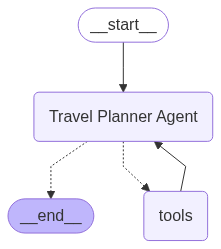

In [61]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

TravelAgent_workflow_builder = StateGraph(MessagesState)

## Add SupervisorNode 
TravelAgent_workflow_builder.add_node("Travel Planner Agent", supervisor)

## Add all above tools, myTools
TravelAgent_workflow_builder.add_node("tools", ToolNode(mytools))

## Add edges for decision making
TravelAgent_workflow_builder.add_edge(START, "Travel Planner Agent")

## Add Conditions
TravelAgent_workflow_builder.add_conditional_edges("Travel Planner Agent", tools_condition,)

## Add Conditions
TravelAgent_workflow_builder.add_edge("tools","Travel Planner Agent")

## React and Action
react_graph = TravelAgent_workflow_builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))


In [63]:
message = [HumanMessage(content="what is 2 times of a nrendraamodi's age ?")]

response = react_graph.invoke({"messages": message})
response

{'messages': [HumanMessage(content="what is 2 times of a nrendraamodi's age ?", additional_kwargs={}, response_metadata={}, id='990f1f66-2144-4cb5-8e78-ebfe3943d353'),
  AIMessage(content="To determine two times Narendra Modi's age, we first need to establish his current age. Narendra Modi was born on September 17, 1950. As of 2023, he is 73 years old. Multiplying this by two gives us:\n\n\\[\n2 \\times 73 = 146\n\\]\n\nSo, two times Narendra Modi's age is **146**. Let me know if you need further assistance!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 268, 'prompt_tokens': 267, 'total_tokens': 535, 'completion_time': 1.073233551, 'prompt_time': 0.017238432, 'queue_time': 0.057733941999999996, 'total_time': 1.090471983}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--b9af5a2e-19b8-4fb9-8273-ab73dd33e450-0', usage_metadata={'input_tokens': 267, 'output_tokens': 

In [64]:
message = [HumanMessage(content="How much is the net worth of elon musk and divided by 2 ?")]
response = react_graph.invoke({"messages": message})
response

{'messages': [HumanMessage(content='How much is the net worth of elon musk and divided by 2 ?', additional_kwargs={}, response_metadata={}, id='4c580757-db0c-4588-8946-9f3da3af1a45'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yswm97w8m', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 352, 'prompt_tokens': 269, 'total_tokens': 621, 'completion_time': 1.9046034779999998, 'prompt_time': 0.025062472, 'queue_time': 0.05636221799999999, 'total_time': 1.92966595}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--aaa9fe0c-dc22-4681-ad76-a13ce08f6d1c-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'yswm97w8m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 269, 'output_tokens': 352, 'total_tok

In [87]:
message = [HumanMessage(content="TravelAgent, what is the waetehr in Hyderabad and Attractions in Hyderabad")]
response = react_graph.invoke({"messages": message})
response

{'messages': [HumanMessage(content='TravelAgent, what is the waetehr in Hyderabad and Attractions in Hyderabad', additional_kwargs={}, response_metadata={}, id='b9d73707-2929-40ce-91e3-d921bc299ac5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '92467sp2j', 'function': {'arguments': '{"query":"Hyderabad weather"}', 'name': 'Weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 276, 'prompt_tokens': 268, 'total_tokens': 544, 'completion_time': 1.18521829, 'prompt_time': 0.017214646, 'queue_time': 0.051062314, 'total_time': 1.2024329360000001}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84b335b2-6ec4-4d60-9625-1388e892615b-0', tool_calls=[{'name': 'Weather', 'args': {'query': 'Hyderabad weather'}, 'id': '92467sp2j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 268, 'output_tokens': 276, 'total_tokens': 544}),
  ToolMessag

In [88]:
##### Final Answer 

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

TravelAgent, what is the waetehr in Hyderabad and Attractions in Hyderabad
================================== Ai Message ==================================
Tool Calls:
  Weather (92467sp2j)
 Call ID: 92467sp2j
  Args:
    query: Hyderabad weather
================================= Tool Message =================================
Name: Weather

Error: TypeError("__init__() should return None, not 'str'")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (hqgvjc85a)
 Call ID: hqgvjc85a
  Args:
    query: Hyderabad weather
================================= Tool Message =================================
Name: duckduckgo_search

Get today's real-time weather updates in Hyderabad with hourly temperatures and a weekly forecast. Find out about Hyderabad's temperature trends, rain chances, air quality (AQI), and humidity ... Hyd